In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
df_features_market = pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/features_market.parquet"
)
df_presence = pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/sp500_universe.parquet"
)

In [3]:
df_features_market

,date,permno,mkt_log_ret,mkt_cap_rank,mkt_mom_1m,mkt_mom_3m,mkt_volatility,mkt_drawdown,mkt_turnover,mkt_rel_vol,mkt_liq_risk
0,2007-01-03,10078,0.021898,0.751529,0.000000,0.000000,-4.605070,0.0,0.017925,0.69,0.0
1,2007-01-04,10078,0.026716,0.771145,0.000000,0.000000,-4.605070,0.0,0.015225,0.69,0.001754
2,2007-01-05,10078,-0.015943,0.763859,0.000000,0.000000,-4.605070,0.0,0.013224,0.69,0.001783
3,2007-01-08,10078,0.008889,0.768775,0.000000,0.000000,-4.605070,0.0,0.011669,0.69,0.001767
4,2007-01-09,10078,0.01406,0.779533,0.000000,0.000000,-4.605070,0.0,0.014076,0.680853,0.001745
...,...,...,...,...,...,...,...,...,...,...,...
255658,2024-12-24,93436,0.070991,2.74525,0.270950,0.549221,-3.356946,-0.037324,0.01832,0.517379,0.001016
255659,2024-12-26,93436,-0.017787,2.736065,0.293594,0.542388,-3.383256,-0.055111,0.023519,0.623304,0.000132
255660,2024-12-27,93436,-0.050745,2.706619,0.243913,0.467393,-3.370154,-0.105856,0.025336,0.6523,0.00051
255661,2024-12-30,93436,-0.033569,2.692358,0.226257,0.429342,-3.381642,-0.139425,0.019957,0.53752,0.000455


In [7]:
df_lr = df_features_market.pivot(index="date", columns="permno", values="mkt_log_ret")

<Axes: xlabel='date'>

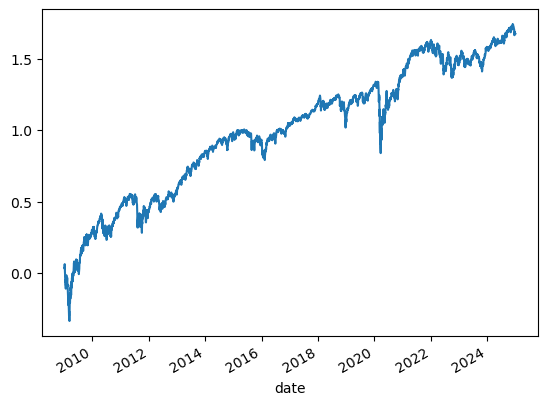

In [12]:
df_lr[df_presence.astype(bool)].mean(1).cumsum().plot()

In [13]:
import wrds

In [14]:
try:
    db_num = wrds.Connection(wrds_username="audricms")
    print("Connection successful via .pgpass!")
except Exception as e:
    print(f"Connection failed: {e}")

Loading library list...
Done
Connection successful via .pgpass!


In [15]:
query = f"""
SELECT *
FROM ff.fivefactors_daily
WHERE date >= '2008-01-01'
"""

df_wrds_factors = db_num.raw_sql(query)

<Axes: xlabel='date'>

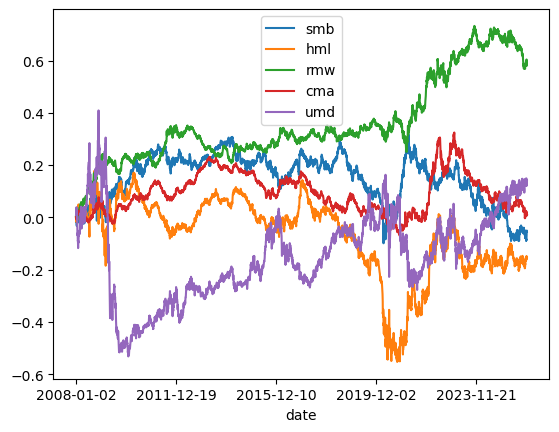

In [20]:
df_wrds_factors.set_index("date").drop(columns=["mktrf", "rf"]).cumsum().plot()

✅ Loaded 4026 days of factor data.
Range: 2009-01-02 to 2024-12-31
Factors: ['MKT', 'SMB', 'HML', 'UMD', 'QMJ', 'BAB']


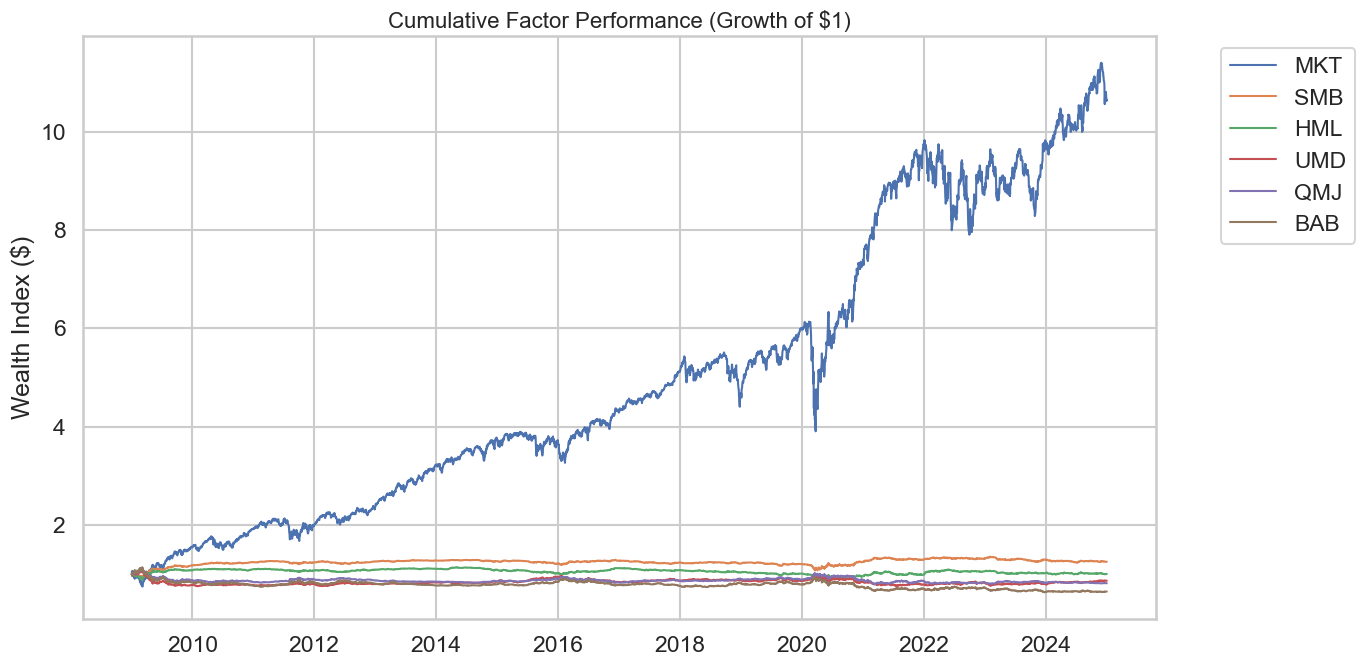

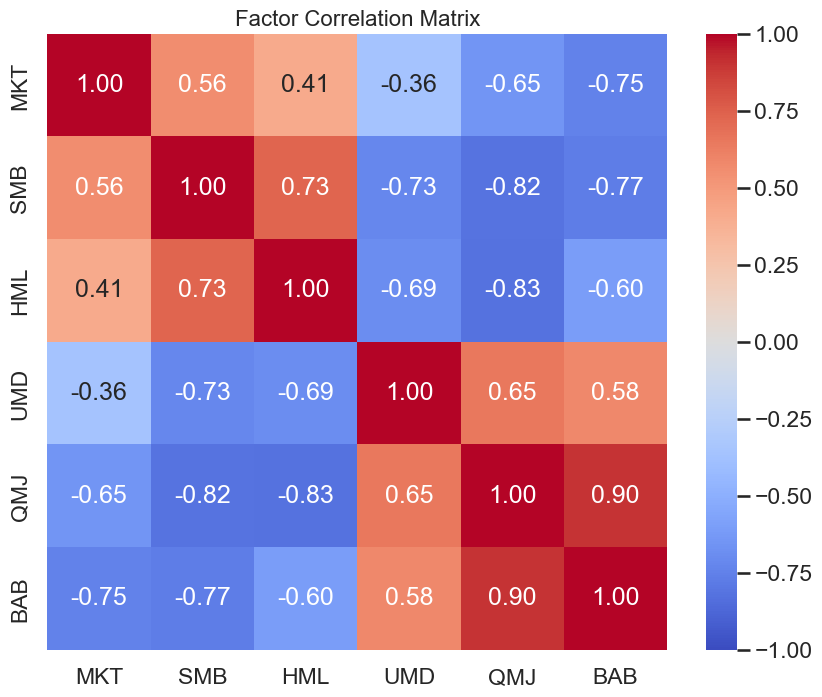


--- Factor Statistics (Annualized) ---


,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,t-stat,Skewness
MKT,0.1480,0.1959,0.7553,-0.3839,3.0189,-0.2802
SMB,0.0143,0.0494,0.2886,-0.1716,1.1534,0.7981
HML,0.0005,0.0580,0.0083,-0.2185,0.0333,0.4916
UMD,-0.0090,0.0809,-0.1111,-0.3351,-0.4442,-1.1266
QMJ,-0.0127,0.0727,-0.1741,-0.3216,-0.6958,-0.7191
BAB,-0.0272,0.1026,-0.2651,-0.4815,-1.0594,-0.4472



--- Bootstrap Analysis (95% Confidence Intervals) ---


,Sharpe (Lower 5%),Sharpe (Median),Robust?
MKT,0.3738,0.7758,✅
SMB,-0.1500,0.2919,⚠️
HML,-0.4273,0.0272,⚠️
UMD,-0.4847,-0.1031,⚠️
QMJ,-0.5712,-0.2064,⚠️
BAB,-0.6437,-0.2880,⚠️



--- Performance by Decade (Ann. Return) ---


,MKT,SMB,HML,UMD,QMJ,BAB
Decade,,,,,,
2000,43.14%,16.24%,7.53%,-25.12%,-12.61%,-17.41%
2010,13.62%,0.28%,-0.61%,1.02%,0.12%,-0.57%
2020,11.48%,0.75%,-0.14%,0.11%,-1.77%,-4.08%



--- Recent Performance (2020 - Present) ---


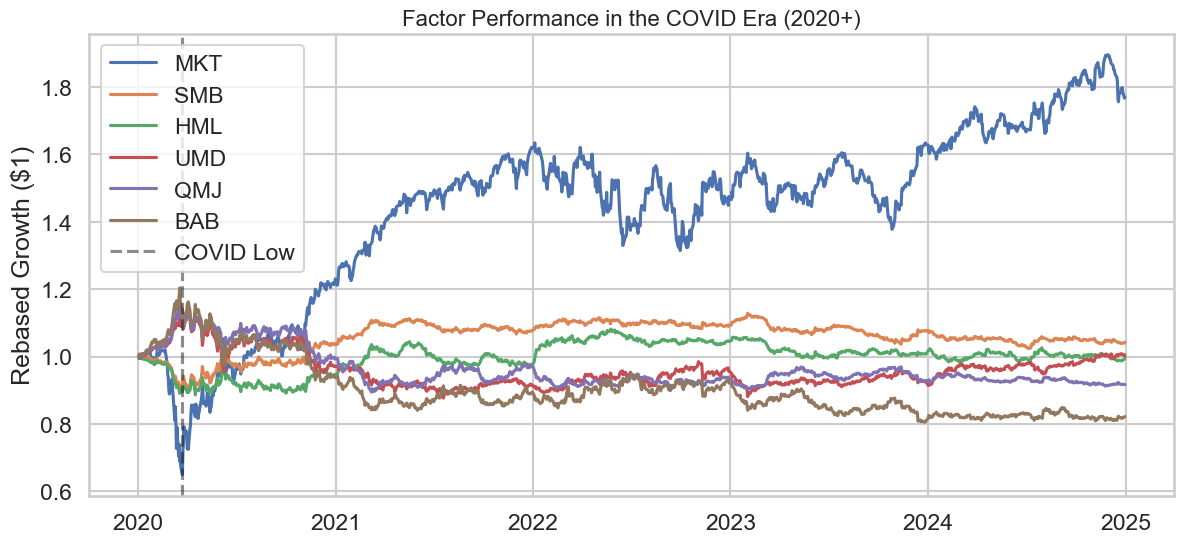

In [32]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust path to import src
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from src.evaluation.performance import compute_metrics
from src.evaluation.robustness import bootstrap_analysis, compute_t_stat

# --- Config ---
# Set plotting style
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = project_root / "data" / "processed" / "factors_returns.parquet"

# 1. Load Data
if not DATA_PATH.exists():
    print(f"❌ File not found: {DATA_PATH}")
else:
    df_factors = pd.read_parquet(DATA_PATH)
    # Ensure index is Datetime
    if "date" in df_factors.columns:
        df_factors = df_factors.set_index("date")

    print(f"✅ Loaded {len(df_factors)} days of factor data.")
    print(f"Range: {df_factors.index.min().date()} to {df_factors.index.max().date()}")
    print(f"Factors: {list(df_factors.columns)}")

# 2. Cumulative Wealth Plot (The "Growth of $1")
# We use Log Returns -> cumsum -> exp to get the wealth index
wealth_index = np.exp(df_factors.cumsum())

plt.figure(figsize=(14, 7))
for col in wealth_index.columns:
    plt.plot(wealth_index.index, wealth_index[col], label=col, linewidth=1.5)

plt.title("Cumulative Factor Performance (Growth of $1)", fontsize=16)
plt.ylabel("Wealth Index ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 3. Correlation Matrix (The "Sanity Check")
# We expect specific relationships:
# - HML vs UMD: Negative (Value vs Momentum usually anti-correlated)
# - BAB vs MKT: Low or Negative (Low Beta is defensive)
# - SMB vs MKT: Positive (Small caps have higher beta)
corr_matrix = df_factors.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Factor Correlation Matrix", fontsize=16)
plt.show()

# 4. Statistical Performance Report
print("\n--- Factor Statistics (Annualized) ---")
stats_list = []

for col in df_factors.columns:
    # Use our robust metrics engine
    m = compute_metrics(df_factors[col], period=252)
    t_stat = compute_t_stat(df_factors[col])

    # Add t-stat to the series
    m["t-stat"] = t_stat
    m.name = col
    stats_list.append(m)

df_stats = pd.DataFrame(stats_list)
# Display key metrics sorted by Sharpe
display_cols = [
    "Annualized Return",
    "Annualized Vol",
    "Sharpe Ratio",
    "Max Drawdown",
    "t-stat",
    "Skewness",
]
display(df_stats[display_cols].sort_values("Sharpe Ratio", ascending=False))

# 5. Robustness: Bootstrap Analysis
# "Is the Sharpe Ratio real, or just luck?"
# We use Block Bootstrap to preserve serial correlation (volatility clustering)
print("\n--- Bootstrap Analysis (95% Confidence Intervals) ---")
robustness_results = {}

for col in df_factors.columns:
    # Run 1000 block bootstraps
    ci = bootstrap_analysis(df_factors[col], n_samples=1000, block_size=22)

    # We care about the 5% lower bound of the Sharpe Ratio
    sharpe_lower = ci.loc["Sharpe Ratio", "5%"]
    sharpe_median = ci.loc["Sharpe Ratio", "50%"]

    robustness_results[col] = {
        "Sharpe (Lower 5%)": sharpe_lower,
        "Sharpe (Median)": sharpe_median,
        "Robust?": "✅" if sharpe_lower > 0 else "⚠️",
    }

df_robust = pd.DataFrame(robustness_results).T
display(df_robust.sort_values("Sharpe (Median)", ascending=False))

# 6. Decade Stability Test
# A good factor should work across different regimes (2000s, 2010s, 2020s)
print("\n--- Performance by Decade (Ann. Return) ---")
df_decade = df_factors.copy()
df_decade["Decade"] = (df_decade.index.year // 10) * 10

decade_perf = df_decade.groupby("Decade").mean() * 252
display(
    decade_perf.style.background_gradient(cmap="RdYlGn", axis=None).format("{:.2%}")
)

# 7. Recent Regime Check (Post-COVID)
# Zoom in on 2020-Present to see behavior during the crash and recovery
print("\n--- Recent Performance (2020 - Present) ---")
recent_df = df_factors[df_factors.index >= "2020-01-01"]

if not recent_df.empty:
    recent_wealth = np.exp(recent_df.cumsum())
    # Rebase to 1.0 at start of period
    recent_wealth = recent_wealth / recent_wealth.iloc[0]

    plt.figure(figsize=(14, 6))
    for col in recent_wealth.columns:
        plt.plot(recent_wealth.index, recent_wealth[col], label=col)

    plt.title("Factor Performance in the COVID Era (2020+)", fontsize=16)
    plt.axvline(
        pd.Timestamp("2020-03-23"),
        color="k",
        linestyle="--",
        alpha=0.5,
        label="COVID Low",
    )
    plt.ylabel("Rebased Growth ($1)")
    plt.legend()
    plt.show()
else:
    print("⚠️ Data ends before 2020.")